# Capstone Project
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data Description](#data_description)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: <a name="introduction"></a>

The city of Edinburgh has a population of approximately 540,000 and with it being the capital and economic centre of Scotland, many professionals and families feel its centripetal pull and will be looking for suitable areas of the city to live. 

Two important location factors of interest to real estate agents and prospective home owners will be the quality of the schools and the local community/culture. Equipped with this information realtors can then estimate the cost 
of a particular property.

In this project we'll look at the type of venues across Edinburgh and create a choropleth map highlighting school catchment areas alongside their academic results in order to get a better grasp of the city's ideal locations.

## Data Description: <a name="data_description"></a>

In [25]:
import numpy as np # library to handle data in a vectorized manner
import geocoder # import geocoder
import geopandas as gpd #!conda install -c conda-forge geopandas

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import matplotlib.pyplot as plt
%matplotlib inline

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [26]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/EH_postcode_area')
dfs

[                                            Edinburgh  \
 0                        United Kingdom postcode area   
 1   .mw-parser-output .locmap .od{position:absolut...   
 2   Coordinates: .mw-parser-output .geo-default,.m...   
 3                                             Country   
 4                                       Postcode area   
 5                                  Postcode area name   
 6                                          Post towns   
 7                                  Postcode districts   
 8                                    Postcode sectors   
 9                                    Postcodes (live)   
 10                                  Postcodes (total)   
 11                       Statistics as at May 2020[1]   
 
                                           Edinburgh.1  
 0                        United Kingdom postcode area  
 1   .mw-parser-output .locmap .od{position:absolut...  
 2   Coordinates: .mw-parser-output .geo-default,.m...  
 3              

In [27]:
#Combine Edinburgh (dfs[1]) with the greater Edinburgh area (dfs[2]) 

dfs2=[dfs[1],dfs[2]]
edin_df=pd.concat(dfs2)

#Drop superfluous final column
edin_df.drop(columns=['Local authority area(s)'], inplace=True)

#edin_df.sort_values(by='Postcode district', inplace=True)
edin_df.reset_index(drop=True, inplace=True)

print(edin_df.shape)

edin_df.head()

(58, 3)


,Postcode district,Post town,Coverage
0,EH1,EDINBURGH,Mostly consists of Edinburgh's Old Town. Also ...
1,EH2,EDINBURGH,The New Town and central commercial area of Ed...
2,EH3,EDINBURGH,An odd shaped area surrounding EH1 and EH2 to ...
3,EH4,EDINBURGH,Radiates from the older and more central areas...
4,EH5,EDINBURGH,Based on a village formerly separate from the ...


In [28]:
address = 'Edinburgh'

geolocator = Nominatim(user_agent="edin_finder")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Edinburgh\'s latitiude is {}°, and its longitude is {}°.'.format(latitude, longitude))

Edinburgh's latitiude is 55.9533456°, and its longitude is -3.1883749°.


In [29]:
#saved txt file in local directory from http://download.geonames.org/export/zip/GB.zip
file='file:///C:/Users/david/Desktop\GB.txt'

#Name columns for future merge
col_names=['Postcode district','Area','Latitude','Longitude']

#read tabular data with seperator '\t'
coord_df = pd.read_csv(file,sep='\t',usecols=[1,2,9,10],names=col_names,index_col=0)
coord_df.head()

,Area,Latitude,Longitude
Postcode district,,,
DN14,Reedness,53.6993,-0.7986
DN14,Saltmarshe,53.7216,-0.8049
DN14,Barmby on the Marsh,53.7490,-0.9561
DN14,Hook,53.7205,-0.8479
DN14,Snaith,53.6911,-1.0286


In [30]:
edin_latlit_df=pd.merge(edin_df, coord_df, on='Postcode district')
edin_latlit_df.head()

,Postcode district,Post town,Coverage,Area,Latitude,Longitude
0,EH1,EDINBURGH,Mostly consists of Edinburgh's Old Town. Also ...,Edinburgh,55.9521,-3.1965
1,EH2,EDINBURGH,The New Town and central commercial area of Ed...,Edinburgh,55.9521,-3.1965
2,EH3,EDINBURGH,An odd shaped area surrounding EH1 and EH2 to ...,Edinburgh,55.9521,-3.1965
3,EH4,EDINBURGH,Radiates from the older and more central areas...,Cramond,55.9710,-3.2915
4,EH4,EDINBURGH,Radiates from the older and more central areas...,Blackhall,55.9622,-3.2606


In [31]:
# create map of Edinburgh using latitude and longitude values
edin_map = folium.Map(location=[latitude, longitude],zoom_start=10)

# add markers to map
for lat, lng, post_town, area in zip(edin_latlit_df['Latitude'], edin_latlit_df['Longitude'], edin_latlit_df['Post town'],edin_latlit_df['Area']):
    label = '{}, {}'.format(area, post_town)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(edin_map)  
    
edin_map

In [32]:
#create json file with the foursquare credentials 
with open(r'C:\Users\david\Desktop\DataScience\Coursera\IBM Course\9 - Applied Data Science Capstone\CityLocation\Coursera_Capstone_2021\4SquareCredentials.json') as f:
    data = json.load(f)
    foursquare_credentials = {'CLIENT_ID':data['CLIENT_ID'],'CLIENT_SECRET':data['CLIENT_SECRET'],'VERSION':data['VERSION']}
    
CLIENT_ID = foursquare_credentials['CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = foursquare_credentials['CLIENT_SECRET'] # your Foursquare Secret
VERSION = foursquare_credentials['VERSION'] # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Function to get venues within a 500m radius of an area and create the new dataframe, edin_venues 

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
edin_venues = getNearbyVenues(names=edin_latlit_df['Area'],
                                   latitudes=edin_latlit_df['Latitude'],
                                   longitudes=edin_latlit_df['Longitude']
                                  )

Edinburgh
Edinburgh
Edinburgh
Cramond
Blackhall
Edinburgh
Edinburgh
Edinburgh
Leith
Edinburgh
Edinburgh
Edinburgh
Hillend
Fairmilehead
Morningside
Edinburgh
Edinburgh
Colinton
Juniper Green
Currie
Balerno
Craiglockhart
Hermiston
Malleny Mills
Portobello
Duddingston
Joppa
Craigmillar
Liberton
Niddrie
Gilmerton
Kaimes
Newbridge
Ratho
Ratho Station
Kirkliston
Abercorn
Dalmeny
South Queensferry
City of Edinburgh
City of Edinburgh
City of Edinburgh
Polton
Bonnyrigg
Loanhead
Straiton
Musselburgh
Inveresk
Wallyford
Levenhall
Newcraighall
Crossgatehall
Old Craighall
Whitecraig
Lasswade
Danderhall
Millerhill
Dalkeith
Eskbank
Easthouses
Mayfield
Newtongrange
Cousland
North Middleton
Borthwick
Carrington
Middleton
Temple
Gorebridge
Newlandrig
Arniston Engine
Rosewell
Roslin
Bilston
Auchendinny
Milton Bridge
Nine Mile Burn
Silverburn
Penicuik
Howgate
Carlops
Kirknewton
Wilkieston
Gullane
Prestonpans
Longniddry
Luffness
Aberlady
Cockenzie and Port Seton
Spittal
Ballencrieff
Macmerry
Tranent
Gladsmu

In [35]:
#check size
print(edin_venues.shape)

#number of venues per area
edin_venues.groupby('Area').count()

(1417, 7)


,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Area,,,,,,
Abercorn,3,3,3,3,3,3
Aberlady,4,4,4,4,4,4
Addiewell,2,2,2,2,2,2
Armadale,2,2,2,2,2,2
Athelstaneford,2,2,2,2,2,2
Auchendinny,1,1,1,1,1,1
Auldhame,2,2,2,2,2,2
Balerno,4,4,4,4,4,4
Ballencrieff,5,5,5,5,5,5


#### The number of unique categories that can be curated from all the returned venues

In [36]:
print('There are {} uniques categories.'.format(len(edin_venues['Venue Category'].unique())))

There are 145 uniques categories.


In [37]:
# one hot encoding
edin_onehot = pd.get_dummies(edin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
edin_onehot['Area'] = edin_venues['Area'] 

# define a list of column names
cols = edin_onehot.columns.tolist()

# move Area column to the first column and use .reindex() function to reorder
cols.insert(0, cols.pop(cols.index('Area')))
edin_onehot = edin_onehot.reindex(columns= cols)

edin_onehot.head()

,Area,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,Auto Workshop,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Garden,Betting Shop,Bistro,Bookstore,Boutique,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Electronics Store,English Restaurant,Event Service,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flower Shop,Food,Food Court,Food Truck,Forest,Fountain,Frame Store,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Lake,Market,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Museum,Music Venue,Neighborhood,Newsagent,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Palace,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Recreation Center,Rental Car Location,Restaurant,River,Rugby Pitch,Sandwich Place,Scenic Lookout,Science Museum,Scottish Restaurant,Seafood Restaurant,Shopping Mall,Skate Park,Smoothie Shop,Soccer Field,Spanish Restaurant,Speakeasy,Steakhouse,Supermarket,Surf Spot,Tapas Restaurant,Tea Room,Thai Restaurant,Tour Provider,Toy / Game Store,Trail,Train Station,Tram Station,Vacation Rental,Vegetarian / Vegan Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop
0,Edinburgh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Edinburgh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Edinburgh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Edinburgh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Edinburgh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
# group rows by Area and by taking the mean of the frequency of occurrence of each category
edin_grouped = edin_onehot.groupby('Area').mean().reset_index()
edin_grouped.head()

,Area,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,Auto Workshop,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Garden,Betting Shop,Bistro,Bookstore,Boutique,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Electronics Store,English Restaurant,Event Service,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flower Shop,Food,Food Court,Food Truck,Forest,Fountain,Frame Store,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Lake,Market,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Museum,Music Venue,Neighborhood,Newsagent,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Palace,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Recreation Center,Rental Car Location,Restaurant,River,Rugby Pitch,Sandwich Place,Scenic Lookout,Science Museum,Scottish Restaurant,Seafood Restaurant,Shopping Mall,Skate Park,Smoothie Shop,Soccer Field,Spanish Restaurant,Speakeasy,Steakhouse,Supermarket,Surf Spot,Tapas Restaurant,Tea Room,Thai Restaurant,Tour Provider,Toy / Game Store,Trail,Train Station,Tram Station,Vacation Rental,Vegetarian / Vegan Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop
0,Abercorn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aberlady,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Addiewell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Armadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [39]:
# Show each Area along with the top 5 most common venues
num_top_venues = 5

for area in edin_grouped['Area']:
    print("----"+area+"----")
    temp = edin_grouped[edin_grouped['Area'] == area].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abercorn----
                venue  freq
0            Bus Stop  0.67
1       Grocery Store  0.33
2  African Restaurant  0.00
3                Park  0.00
4           Newsagent  0.00


----Aberlady----
                venue  freq
0                 Bar  0.25
1               Beach  0.25
2          Restaurant  0.25
3  Seafood Restaurant  0.25
4           Newsagent  0.00


----Addiewell----
                venue  freq
0         Pet Service   0.5
1       Train Station   0.5
2  African Restaurant   0.0
3              Palace   0.0
4        Neighborhood   0.0


----Armadale----
                venue  freq
0                 Pub   0.5
1         Golf Course   0.5
2  African Restaurant   0.0
3              Palace   0.0
4        Neighborhood   0.0


----Athelstaneford----
                venue  freq
0     Vacation Rental   0.5
1               Beach   0.5
2  African Restaurant   0.0
3              Palace   0.0
4        Neighborhood   0.0


----Auchendinny----
                venue  freq
0         

                venue  freq
0                 Pub  0.50
1       Historic Site  0.25
2       Grocery Store  0.25
3  African Restaurant  0.00
4                Park  0.00


----Easthouses----
                venue  freq
0   Mobile Phone Shop   1.0
1  African Restaurant   0.0
2         Music Venue   0.0
3           Newsagent   0.0
4   Other Repair Shop   0.0


----Ecclesmachan----
               venue  freq
0  Convenience Store   0.5
1      Grocery Store   0.5
2               Park   0.0
3       Neighborhood   0.0
4          Newsagent   0.0


----Eddleston----
                venue  freq
0               Hotel   1.0
1  African Restaurant   0.0
2                Park   0.0
3           Newsagent   0.0
4   Other Repair Shop   0.0


----Edinburgh----
                venue  freq
0                Café  0.08
1                 Bar  0.07
2                 Pub  0.06
3  Seafood Restaurant  0.04
4        Cocktail Bar  0.04


----Elphinstone----
                venue  freq
0               Hotel   1.0
1  A

                venue  freq
0                Park  0.33
1         Golf Course  0.33
2          Campground  0.33
3  African Restaurant  0.00
4           Newsagent  0.00


----Lyne Station----
                venue  freq
0                Park  0.33
1         Golf Course  0.33
2          Campground  0.33
3  African Restaurant  0.00
4           Newsagent  0.00


----Malleny Mills----
                venue  freq
0                 Pub  0.33
1       Grocery Store  0.33
2                Park  0.33
3  African Restaurant  0.00
4              Palace  0.00


----Mayfield----
                venue  freq
0   Mobile Phone Shop   1.0
1  African Restaurant   0.0
2         Music Venue   0.0
3           Newsagent   0.0
4   Other Repair Shop   0.0


----Meadowmill----
                venue  freq
0               Hotel   1.0
1  African Restaurant   0.0
2                Park   0.0
3           Newsagent   0.0
4   Other Repair Shop   0.0


----Mid Calder----
                venue  freq
0                 Pub  0

                venue  freq
0                Café   1.0
1  African Restaurant   0.0
2         Music Venue   0.0
3           Newsagent   0.0
4   Other Repair Shop   0.0


----Wallyford----
                venue  freq
0      Discount Store   0.2
1                Park   0.1
2         Coffee Shop   0.1
3      Ice Cream Shop   0.1
4  Italian Restaurant   0.1


----West Calder----
                venue  freq
0   Indian Restaurant  0.50
1       Grocery Store  0.25
2       Train Station  0.25
3  African Restaurant  0.00
4              Palace  0.00


----West Linton----
           venue  freq
0     Playground   0.2
1            Pub   0.2
2     Steakhouse   0.2
3  Grocery Store   0.2
4           Café   0.2


----West Saltoun----
                venue  freq
0    Business Service   1.0
1  African Restaurant   0.0
2         Music Venue   0.0
3           Newsagent   0.0
4   Other Repair Shop   0.0


----Wester Dechmont----
               venue  freq
0  Convenience Store   0.5
1      Grocery Store   

#### Dataframe displaying the top 10 venues for each neighborhood

In [40]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Area'] = edin_grouped['Area']

for ind in np.arange(edin_grouped.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(edin_grouped.iloc[ind, :], num_top_venues)

area_venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abercorn,Bus Stop,Grocery Store,Wine Shop,English Restaurant,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,Electronics Store
1,Aberlady,Bar,Seafood Restaurant,Restaurant,Beach,Wine Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service
2,Addiewell,Pet Service,Train Station,Wine Shop,Electronics Store,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
3,Armadale,Pub,Golf Course,Wine Shop,Electronics Store,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
4,Athelstaneford,Vacation Rental,Beach,Wine Shop,English Restaurant,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service


#### Cluster Neighborhoods

In [42]:
edin_grouped_clustering = edin_grouped.drop('Area', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(edin_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    

In [43]:
edin_grouped_clustering.nunique().head()

African Restaurant     2
American Restaurant    3
Art Gallery            4
Art Museum             3
Arts & Crafts Store    2
dtype: int64

In [44]:
X=edin_grouped_clustering

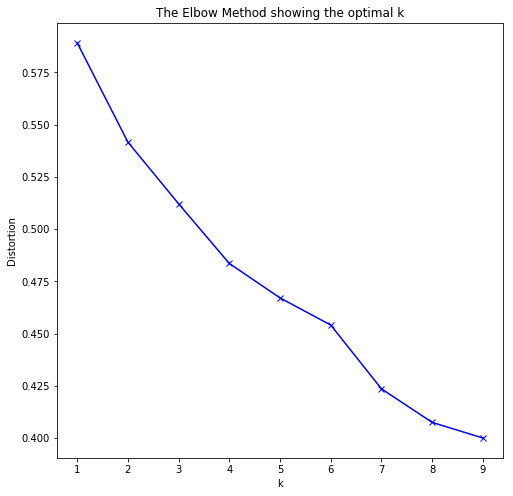

In [47]:
plt.figure(figsize=(8,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [48]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(edin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 4, 4, 4, 4, 5, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3])

In [49]:
# add clustering labels
area_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)
area_venues_sorted.head()

,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Abercorn,Bus Stop,Grocery Store,Wine Shop,English Restaurant,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,Electronics Store
1,4,Aberlady,Bar,Seafood Restaurant,Restaurant,Beach,Wine Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service
2,4,Addiewell,Pet Service,Train Station,Wine Shop,Electronics Store,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
3,4,Armadale,Pub,Golf Course,Wine Shop,Electronics Store,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
4,4,Athelstaneford,Vacation Rental,Beach,Wine Shop,English Restaurant,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service


In [50]:
area_venues_sorted['Cluster Labels'].unique()

array([0, 4, 5, 3, 1, 2], dtype=int64)

In [52]:
edin_merged = edin_latlit_df

# merge edin_grouped with edin_data to add latitude/longitude for each area
#edin_merged = edin_merged.join(area_venues_sorted.set_index('Area'), on='Area')

edin_merged = edin_merged.join(area_venues_sorted.set_index('Area'), on='Area', how ='inner')

edin_merged.head() # check the last columns!

,Postcode district,Post town,Coverage,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,EH1,EDINBURGH,Mostly consists of Edinburgh's Old Town. Also ...,Edinburgh,55.9521,-3.1965,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
1,EH2,EDINBURGH,The New Town and central commercial area of Ed...,Edinburgh,55.9521,-3.1965,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
2,EH3,EDINBURGH,An odd shaped area surrounding EH1 and EH2 to ...,Edinburgh,55.9521,-3.1965,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
5,EH4,EDINBURGH,Radiates from the older and more central areas...,Edinburgh,55.9622,-3.2606,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
6,EH5,EDINBURGH,Based on a village formerly separate from the ...,Edinburgh,55.9757,-3.2217,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar


In [53]:
edin_merged['Cluster Labels'].unique()

array([4, 0, 1, 3, 5, 2], dtype=int64)

#### Map showing the clusters

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(edin_merged['Latitude'], edin_merged['Longitude'], edin_merged['Area'], edin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
# Cluster 0

edin_merged.loc[edin_merged['Cluster Labels'] == 0, edin_merged.columns[[3] + list(range(6, edin_merged.shape[1]))]]

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Colinton,0,Italian Restaurant,Grocery Store,Beer Garden,Park,Electronics Store,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service
19,Currie,0,Grocery Store,Café,Pub,Park,Wine Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
20,Balerno,0,Grocery Store,Gastropub,Rugby Pitch,Dive Bar,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Electronics Store
21,Craiglockhart,0,Park,Grocery Store,Pub,Dive Bar,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Electronics Store
22,Hermiston,0,Park,Grocery Store,Pub,Dive Bar,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Electronics Store
23,Malleny Mills,0,Park,Grocery Store,Pub,Dive Bar,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Electronics Store
27,Craigmillar,0,Bakery,Clothing Store,Grocery Store,Skate Park,Cupcake Shop,Cosmetics Shop,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar
29,Niddrie,0,Hotel,Grocery Store,Bed & Breakfast,Wine Shop,English Restaurant,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
30,Gilmerton,0,Pizza Place,Grocery Store,Fast Food Restaurant,Supermarket,Wine Shop,Electronics Store,Fish & Chips Shop,Farmers Market,Event Service,English Restaurant
31,Kaimes,0,Pizza Place,Grocery Store,Fast Food Restaurant,Supermarket,Wine Shop,Electronics Store,Fish & Chips Shop,Farmers Market,Event Service,English Restaurant


In [56]:
# Cluster 1

edin_merged.loc[edin_merged['Cluster Labels'] == 1, edin_merged.columns[[3] + list(range(6, edin_merged.shape[1]))]]

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Old Craighall,1,Mobile Phone Shop,Wine Shop,Food Court,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
53,Whitecraig,1,Mobile Phone Shop,Wine Shop,Food Court,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
58,Eskbank,1,Mobile Phone Shop,Wine Shop,Food Court,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
59,Easthouses,1,Mobile Phone Shop,Wine Shop,Food Court,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
60,Mayfield,1,Mobile Phone Shop,Wine Shop,Food Court,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
61,Newtongrange,1,Mobile Phone Shop,Wine Shop,Food Court,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
62,Cousland,1,Mobile Phone Shop,Wine Shop,Food Court,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant


In [57]:
# Cluster 2 
edin_merged.loc[edin_merged['Cluster Labels'] == 2, edin_merged.columns[[3] + list(range(6, edin_merged.shape[1]))]]

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Howgate,2,Forest,Wine Shop,Food,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Electronics Store
93,Gladsmuir,2,Forest,Wine Shop,Food,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Electronics Store


In [58]:
#Cluster 3

edin_merged.loc[edin_merged['Cluster Labels'] == 3, edin_merged.columns[[3] + list(range(6, edin_merged.shape[1]))]]

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Borthwick,3,Castle,Hotel,Electronics Store,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant
94,Elvingston,3,Hotel,Wine Shop,English Restaurant,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,Electronics Store
95,Elphinstone,3,Hotel,Wine Shop,English Restaurant,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,Electronics Store
96,Meadowmill,3,Hotel,Wine Shop,English Restaurant,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,Electronics Store
97,New Winton,3,Hotel,Wine Shop,English Restaurant,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,Electronics Store
156,Eddleston,3,Hotel,Wine Shop,English Restaurant,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,Electronics Store


In [59]:
#Cluster 4 

edin_merged.loc[edin_merged['Cluster Labels'] == 4, edin_merged.columns[[3] + list(range(6, edin_merged.shape[1]))]]

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
1,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
2,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
5,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
6,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
7,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
9,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
10,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
11,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar
15,Edinburgh,4,Café,Bar,Pub,Hotel,Cocktail Bar,Seafood Restaurant,Scenic Lookout,Mexican Restaurant,Coffee Shop,Whisky Bar


In [60]:
# Cluster 5 

edin_merged.loc[edin_merged['Cluster Labels'] == 5, edin_merged.columns[[3] + list(range(6, edin_merged.shape[1]))]]

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,Auchendinny,5,Café,Construction & Landscaping,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Wine Shop
105,Humbie,5,Café,Construction & Landscaping,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Wine Shop
106,Gilchriston,5,Café,Construction & Landscaping,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Wine Shop
150,Walkerburn,5,Café,Construction & Landscaping,Flower Shop,Fishing Spot,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Event Service,English Restaurant,Wine Shop


# Part 2 - Edinburgh Catchement Areas

In [61]:
#Dataset retrieved from https://statistics.gov.scot/resource?uri=http%3A%2F%2Fstatistics.gov.scot%2Fdata%2Fbreadth-and-depth

url_download='https://statistics.gov.scot/slice/observations.csv?&dataset=http%3A%2F%2Fstatistics.gov.scot%2Fdata%2Fbreadth-and-depth&http%3A%2F%2Fpurl.org%2Flinked-data%2Fcube%23measureType=http%3A%2F%2Fstatistics.gov.scot%2Fdef%2Fmeasure-properties%2Fpercent&http%3A%2F%2Fpurl.org%2Flinked-data%2Fsdmx%2F2009%2Fdimension%23refPeriod=http%3A%2F%2Freference.data.gov.uk%2Fid%2Fgregorian-interval%2F2018-08-01T00%3A00%3A00%2FP1Y&http%3A%2F%2Fstatistics.gov.scot%2Fdef%2Fdimension%2Fcomparator=http%3A%2F%2Fstatistics.gov.scot%2Fdef%2Fconcept%2Fcomparator%2Freal-establishment&http%3A%2F%2Fstatistics.gov.scot%2Fdef%2Fdimension%2Fcourses=http%3A%2F%2Fstatistics.gov.scot%2Fdef%2Fconcept%2Fcourses%2Fall-courses&http%3A%2F%2Fstatistics.gov.scot%2Fdef%2Fdimension%2FscqfLevel=http%3A%2F%2Fstatistics.gov.scot%2Fdef%2Fconcept%2Fscqf-level%2F6-and-above'
url_schools='https://en.wikipedia.org/wiki/List_of_schools_in_Edinburgh'

In [62]:
dfs=pd.read_csv(url_download,skiprows=10)
dfs=dfs.drop(dfs.columns[0], axis=1)

In [63]:
#Remove the word 'Community' and change 'Of' to lowercase 'of' from high school names for future merging
dfs['Reference Establishment']=dfs['Reference Establishment'].str.replace('Community ','').str.replace('Of','of')

In [64]:
#Import beautisful soup for scraping wiki page
from bs4 import BeautifulSoup, Tag


source = requests.get(url_schools).text

soup = BeautifulSoup(source, 'html5lib')


In [65]:
#Find unique id Secondary Schools and find the unordered (bulleted) list <ul> tags, corresponding to the within and 
#outwith Edinburgh lists.

secondary_id=soup.find(id='Secondary_schools')

within_edin=secondary_id.findNext('ul')
outwith_edin=within_edin.findNext('ul')

#Create empty list of Edinburgh High Schools
edin_schools=[]

max_within_edin=len(within_edin.contents)
max_outwith_edin=len(outwith_edin.contents)


#Even numbered elements of the within.contents list are bs4 NavigableString with no text, so create for loop for 
#odd numbered elements to extract the high school names

for i in range(0, max_within_edin+1):
    if(i % 2 == 0):
        edin_schools.append(within_edin.contents[i].text)

for i in range(0, max_outwith_edin+1):
    if(i % 2 == 0):
        edin_schools.append(outwith_edin.contents[i].text)

        
#Check that all the schools were extracted
print(edin_schools,'\n\n','Number of schools:', len(edin_schools))


['Boroughmuir High School', 'Broughton High School', 'Castlebrae Community High School', 'Craigmount High School', 'Craigroyston Community High School', 'Drummond Community High School', 'Firrhill High School', 'Forrester High School', 'Gracemount High School', 'Holyrood High School Edinburgh', "James Gillespie's High School", 'Leith Academy', 'Liberton High School', 'Portobello High School', 'The Royal High School', "St Augustine's High School", "St Thomas of Aquin's High School", 'Trinity Academy, Edinburgh', 'Tynecastle High School', 'Wester Hailes Education Centre', 'Balerno Community High School', 'Currie High School', 'Queensferry High School, South Queensferry'] 

 Number of schools: 23


In [66]:
#Change to dataframe and name column for merge
schools_df=pd.DataFrame(edin_schools,columns = ['Reference Establishment'])


#Remove the word 'Community' from school name and strip some of the school location after the delimiter ',' 
schools_df=schools_df['Reference Establishment'].str.replace('Community ','').str.split(',').str[0]

#Rename Holyrood High School from wiki page to correct name; Holy Rood RC High School.
schools_df=schools_df.str.replace('Holyrood High School Edinburgh','Holy Rood RC High School')

In [67]:
grades_df=pd.merge(dfs, schools_df, on='Reference Establishment')

In [68]:
#This data is for the Academic year 2015-2016 and the numbers indicate the percentage of students who achieved a 
#column's level
#SCQF grade explanations seen here: https://www.hw.ac.uk/uk/services/docs/learning-teaching/policies/scqf.pdf
grades_df

,Reference Establishment,1 And Above,2 And Above,3 And Above,4 And Above,5 And Above,6 And Above,7 And Above,8 And Above,9 And Above,10 And Above
0,Balerno High School,75.0,71.0,67.0,60.0,53.0,35.0,18.0,6.0,NaN,NaN
1,Boroughmuir High School,92.0,89.0,84.0,80.0,72.0,54.0,23.0,5.0,0.0,0.0
2,Broughton High School,61.0,51.0,44.0,35.0,26.0,18.0,7.0,4.0,0.0,0.0
3,Castlebrae High School,35.0,19.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0
4,Craigmount High School,70.0,63.0,58.0,56.0,46.0,28.0,11.0,3.0,NaN,NaN
5,Craigroyston High School,40.0,33.0,27.0,24.0,15.0,11.0,8.0,5.0,0.0,NaN
6,Currie High School,75.0,68.0,64.0,54.0,44.0,32.0,18.0,9.0,NaN,NaN
7,Drummond High School,60.0,49.0,43.0,38.0,26.0,17.0,9.0,NaN,0.0,0.0
8,Firrhill High School,74.0,70.0,64.0,57.0,53.0,40.0,20.0,4.0,NaN,0.0
9,Forrester High School,49.0,42.0,34.0,31.0,23.0,13.0,7.0,NaN,0.0,NaN


In [69]:
#Check that the grades for the Edinburgh outer and inner area schools was successfully retrieved
len(edin_schools)==len(grades_df)

True

In [70]:
#Add RC to St Augustine's High School name so the Nominatim geolocator in the upoming for loop finds the correct 
#coordinates.
grades_df.iat[17,0]="St. Augustine's RC High School"

#Add Latitude and Longitude columns to be filled.
grades_df['Latitude']=None
grades_df['Longitude']=None#Add RC to St Augustine's High School name so the Nominatim geolocator in the upoming for loop finds the correct 
#coordinates.
grades_df.iat[17,0]="St. Augustine's RC High School"

#Add Latitude and Longitude columns to be filled.
grades_df['Latitude']=None
grades_df['Longitude']=None

In [71]:
geolocator = Nominatim(user_agent="edin_explorer")

for i in range(len(grades_df)):
    location = geolocator.geocode('{}, Scotland'.format(grades_df.iat[i,0],))
    grades_df.iat[i,11] = location.latitude
    grades_df.iat[i,12] = location.longitude

In [72]:
#A SCQF of 6 equates to Scottish highers. Change NaN values to 0 for plotting
higher_df=grades_df[['Reference Establishment','6 And Above','Latitude','Longitude']]
higher_df['6 And Above'] = higher_df['6 And Above'].fillna(0)

#Rename columns for merge with geodataframe
higher_df.rename(columns = {'Reference Establishment': 'EST_NAME','6 And Above': '% with Highers'}, inplace=True)

higher_df

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\david\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,EST_NAME,% with Highers,Latitude,Longitude
0,Balerno High School,35.0,55.8868,-3.33845
1,Boroughmuir High School,54.0,55.9369,-3.21112
2,Broughton High School,18.0,55.961,-3.22192
3,Castlebrae High School,0.0,55.929,-3.13504
4,Craigmount High School,28.0,55.945,-3.30569
5,Craigroyston High School,11.0,55.9737,-3.25477
6,Currie High School,32.0,55.8962,-3.32153
7,Drummond High School,17.0,55.9606,-3.19009
8,Firrhill High School,40.0,55.9153,-3.2365
9,Forrester High School,13.0,55.931,-3.28977


In [73]:
#School catchment area geojson file

with open(r'catch_edit.geojson') as f:
    catchment_geo = json.load(f)

In [74]:
scale = (higher_df['% with Highers'].quantile((0,0.3,0.4,0.5,0.6,0.7,0.9,1))).tolist()

In [75]:
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

In [76]:
# create map of Edinburgh using latitude and longitude values
edin_map = folium.Map(location=[latitude, longitude],zoom_start=10)

edin_map.choropleth(
    geo_data=catchment_geo,
    data=higher_df,
    columns=['EST_NAME','% with Highers'],
    key_on='feature.properties.EST_NAME',
    fill_color='YlOrRd',
    legend_name='% of School Leavers with Highers',
    threshold_scale=scale,
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True
)

tooltip=folium.features.GeoJson(
    data=catchment_geo,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['EST_NAME'],
        aliases=['School:'])
    )

tooltip.add_to(edin_map)

edin_map

C:\Users\david\Anaconda3\lib\site-packages\folium\folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
